# Private Sector Travel Time & Congestion Data

1. Private sector data sources
2. Querying data
3. Analyzing data

### Setup

In [1]:
# ! pip install pyarrow

In [2]:
import dask.dataframe as dd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
data_dir = "/Users/robmarty/Dropbox/World Bank/Trainings and Code Resources/LAMATA Workshop 2024/Data"

### Load spatial route files

We'll be working with travel time data from Google. We queried origin-destination data from Google along the following routes

In [4]:
route_file = data_dir + "/Google Travel Time/Final/routes.geojson"
route_gpd = gpd.read_file(route_file)

In [5]:
route_gpd.iloc[[0]].explore()

In [6]:
route_gpd.explore()

### Introduction to Dask

One way to define __big data__ is data beyond what a computers memory (ie, RAM) can hold. An approach to working with big data is to work with the data in "chunks". Specifically, we can break the dataset into sub-datasets. Python will work on one "sub-dataset" at any given point in time, but then collect results.

To illustrate the approach, let's say we want to calculate the minimum value of the following list:

```python
nums = [5,4,3,9,8,7,1,2,3]
```

We could divide this list into three separate lists

```python
nums_1 = [5,4,3]
nums_2 = [9,8,7]
nums_3 = [1,2,3]
```

Then take the minimum value across the three lists, then take the minimum value across those minimum values:

```python
nums_1_min = nums_1.min() # 3
nums_2_min = nums_2.min() # 7
nums_3_min = nums_3.min() # 1

[nums_1_min, nums_2_min, nums_3_min].min() # 1
```

[Dask](https://docs.dask.org/en/stable/) is a python library that supports analyzing big data, building on Python.

### Load travel time data

We'll be working with travel time data. However, we don't have one dataset. We have one dataset for each day. The files are `parquet` files, which are a file format that is commonly used in big data work; parquet files are compressed, so that they take up less space, but are faster to load.

In [7]:
google_tt_dir = os.path.join(data_dir, "Google Travel Time", "Final", "travel_time_monthly")

os.listdir(google_tt_dir)

['google_tt_2022-07-01.parquet',
 'google_tt_2023-04-01.parquet',
 'google_tt_2021-02-01.parquet',
 'google_tt_2020-10-01.parquet',
 'google_tt_2023-09-01.parquet',
 'google_tt_2023-10-01.parquet',
 '.DS_Store',
 'google_tt_2020-09-01.parquet',
 'google_tt_2020-04-01.parquet',
 'google_tt_2021-07-01.parquet',
 'google_tt_2022-02-01.parquet',
 'google_tt_2023-01-01.parquet',
 'google_tt_2022-05-01.parquet',
 'google_tt_2023-06-01.parquet',
 'google_tt_2020-03-01.parquet',
 'google_tt_2022-08-01.parquet',
 'google_tt_2021-11-01.parquet',
 'google_tt_2020-12-01.parquet',
 'google_tt_2021-08-01.parquet',
 'google_tt_2022-11-01.parquet',
 'google_tt_2020-06-01.parquet',
 'google_tt_2021-05-01.parquet',
 'google_tt_2023-03-01.parquet',
 'google_tt_2023-11-01.parquet',
 'google_tt_2022-12-01.parquet',
 'google_tt_2020-08-01.parquet',
 'google_tt_2022-03-01.parquet',
 'google_tt_2020-05-01.parquet',
 'google_tt_2021-06-01.parquet',
 'google_tt_2021-03-01.parquet',
 'google_tt_2022-06-01.parque

From __dask__, we can use the `read_parquet` to load a whole directory of files.

In [8]:
google_tt_df = dd.read_parquet(google_tt_dir)

When we print the dataframe, we don't see much. Dask shows us the variable names and types, but doesn't show us any data. That is because dask lazily computes data; until you ask for a result, dask will wait to do any computation.

In [9]:
google_tt_df

Dask DataFrame Structure:
                                    datetime  name_o  name_d route_name    lat_o    lon_o    lat_d    lon_d speed_kmhr_in_traffic_s duration_in_traffic_s distance_m route_open_anytime     route_opened_date  route_suspended_date
npartitions=45                                                                                                                                                                                                                     
                datetime64[us, Africa/Lagos]  string  string     string  float64  float64  float64  float64                 float64               float64    float64            float64  date32[day][pyarrow]  date32[day][pyarrow]
                                         ...     ...     ...        ...      ...      ...      ...      ...                     ...                   ...        ...                ...                   ...                   ...
...                                      ...     ...     ...        ...      ...      ...      ...      ...                     ...                   ...        ...                ...                   ...                   ...
                                         ...     ...     ...        ...      ...      ...      ...      ...                     ...                   ...        ...                ...                   ...                   ...
                                         ...     ...     ...        ...      ...      ...      ...      ...                     ...                   ...        ...                ...                   ...                   ...
Dask Name: read_parquet, 1 expression
Expr=ReadParquetFSSpec(54529c5)

# Part 1: Explore data

Dask dataframes are designed to work similarly to pandas dataframes, so we can maniupate them in largely the same ways.

## Exercise: Examine Data
1. What variables do we have?
2. How many observations are there?
3. How many routes are there (identified by origin & destination lat/lon)
4. What are the start and end dates?

In [10]:
# Look at variables
google_tt_df.head()

datetime name_o name_d route_name     lat_o     lon_o  \
0 2020-03-25 01:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
1 2020-03-25 02:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
2 2020-03-25 03:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
3 2020-03-25 04:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
4 2020-03-25 05:00:04+01:00     O1    O17   o1 - o17  6.458488  3.387256   

      lat_d     lon_d  speed_kmhr_in_traffic_s  duration_in_traffic_s  \
0  6.475177  3.381537                31.046475                  383.0   
1  6.475177  3.381537                24.217515                  491.0   
2  6.475177  3.381537                24.876151                  478.0   
3  6.475177  3.381537                24.772500                  480.0   
4  6.475177  3.381537                23.734132                  501.0   

   distance_m  route_open_anytime route_opened_date route_suspended_date  
0      3303.0                 0.0              <NA>                 <NA>  
1      3303.0                 0.0              <NA>                 <NA>  
2      3303.0                 0.0              <NA>                 <NA>  
3      3303.0                 0.0              <NA>                 <NA>  
4      3303.0                 0.0              <NA>                 <NA>

We try to get the number of observations. However, when applying functions, we need to explicitly tell dask to __compute__ to get us the result.

In [11]:
# Number of observations
google_tt_df.shape[0]

<dask_expr.expr.Scalar: expr=ReadParquetFSSpec(54529c5).size() // 14, dtype=int64>

In [12]:
# Number of observations
google_tt_df.shape[0].compute()

31663318

In [13]:
# Number of routes
od_df = google_tt_df.groupby(["lat_o", "lon_o", "lat_d", "lon_d"]).size().compute()
od_df.shape

(447,)

# Part 2: Speed over time

## Exercise: Take average speed within each day; plot trends over time

In [14]:
google_tt_df['date'] = google_tt_df['datetime'].dt.date

# 1. groupby date and calculate the average speed
# (speed_kmhr_in_traffic_s)
# Add 'compute' at the end!

# 2. Use sns.lineplot to plots trends in average speed


### Exercise: Take average speed within each week; plot trends over time

In [15]:
# Define a function to round dates to the nearest week
def round_to_nearest_week(df):
    df['week'] = df['datetime'].dt.round('7D')
    return df

# Apply the function to each partition of the Dask DataFrame.
# In dask, instead of 'apply', we use 'map_partitions'
google_tt_df = google_tt_df.map_partitions(round_to_nearest_week)

# USE SIMILAR CODE AS ABOVE TO PLOT TRENDS, BUT NOW BY WEEK

### Exercise: Take average speed by hour of day, plot speeds by hour of day

1. Write a function that adds the hour of day as a variable. This code will extract hour from a datetime variable `df['datetime'].dt.hour`
2. Use `map_partitions` to add this variable to the dask dataframe
3. Create a plot showing average speeds by hour

### Exercise: Take average speed by hour of day AND day of week. Create a figure that plots hour of day for each day of week.

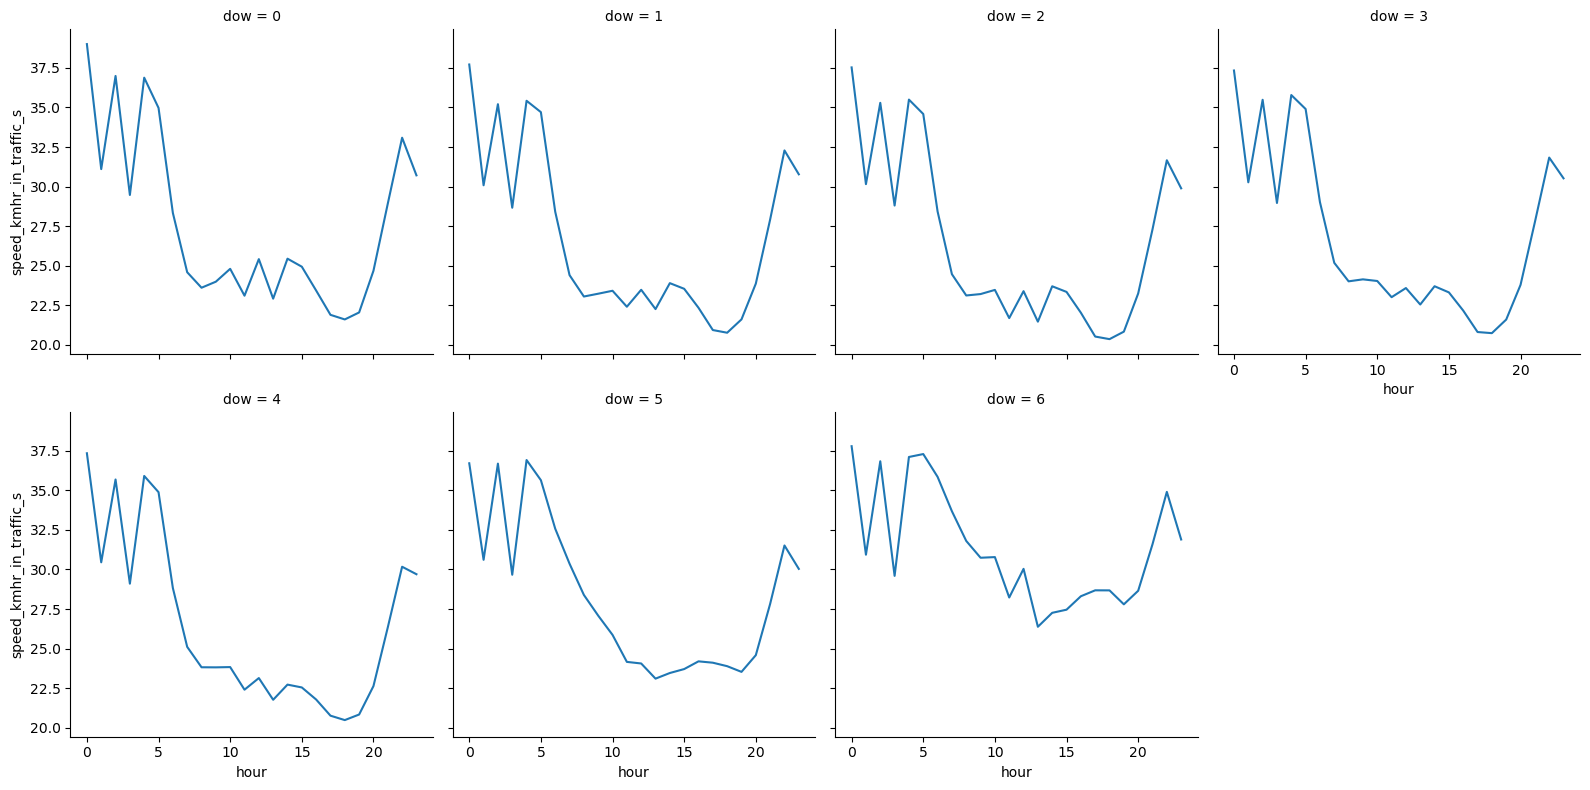

In [16]:
# CREATE DATASET
# Define a function to add hour and day of week variable
def determine_hour_dow(df):
    df['hour'] = df['datetime'].dt.hour
    df['dow'] = df['datetime'].dt.dayofweek
    return df

# Apply the function to each partition of the Dask DataFrame
google_tt_df = google_tt_df.map_partitions(determine_hour_dow)

hour_dow_df = google_tt_df.\
    groupby(['hour', 'dow']).\
    agg({'speed_kmhr_in_traffic_s': 'mean'}).\
    compute().\
    reset_index()

g = sns.FacetGrid(hour_dow_df, col='dow', col_wrap=4, height=4, aspect=1)
g.map(sns.lineplot, 'hour', 'speed_kmhr_in_traffic_s')

### Exercise: Take average speed by hour of day for each year, make a figure plotting speeds by hour of day for each year

__Hint:__ Code will be fairly similar to above

### Exercise: Compare average speed between BRT routes and non-BRT routes

In [17]:
google_tt_df.head()

datetime name_o name_d route_name     lat_o     lon_o  \
0 2020-03-25 01:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
1 2020-03-25 02:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
2 2020-03-25 03:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
3 2020-03-25 04:00:05+01:00     O1    O17   o1 - o17  6.458488  3.387256   
4 2020-03-25 05:00:04+01:00     O1    O17   o1 - o17  6.458488  3.387256   

      lat_d     lon_d  speed_kmhr_in_traffic_s  duration_in_traffic_s  \
0  6.475177  3.381537                31.046475                  383.0   
1  6.475177  3.381537                24.217515                  491.0   
2  6.475177  3.381537                24.876151                  478.0   
3  6.475177  3.381537                24.772500                  480.0   
4  6.475177  3.381537                23.734132                  501.0   

   distance_m  route_open_anytime route_opened_date route_suspended_date  \
0      3303.0                 0.0              <NA>                 <NA>   
1      3303.0                 0.0              <NA>                 <NA>   
2      3303.0                 0.0              <NA>                 <NA>   
3      3303.0                 0.0              <NA>                 <NA>   
4      3303.0                 0.0              <NA>                 <NA>   

         date                      week  hour  dow  
0  2020-03-25 2020-03-26 00:00:00+01:00     1    2  
1  2020-03-25 2020-03-26 00:00:00+01:00     2    2  
2  2020-03-25 2020-03-26 00:00:00+01:00     3    2  
3  2020-03-25 2020-03-26 00:00:00+01:00     4    2  
4  2020-03-25 2020-03-26 00:00:00+01:00     5    2

In [18]:
google_tt_df.loc[google_tt_df.route_open_anytime == 1, 'speed_kmhr_in_traffic_s'].describe().compute()

count    1.215228e+06
mean     2.846525e+01
std      1.319680e+01
min      4.434783e+00
25%      2.143572e+01
50%      2.944360e+01
75%      3.984168e+01
max      8.852016e+01
Name: speed_kmhr_in_traffic_s, dtype: float64

In [19]:
google_tt_df.loc[google_tt_df.route_open_anytime == 0, 'speed_kmhr_in_traffic_s'].describe().compute()

count    3.019557e+07
mean     2.667176e+01
std      1.161413e+01
min      1.915756e+00
25%      2.123642e+01
50%      2.731254e+01
75%      3.520352e+01
max      9.286829e+01
Name: speed_kmhr_in_traffic_s, dtype: float64

### Exercise: Compare distribution of average speeds along BRT and non-BRT routes. Make a figure showing the difference.
1. Compute average speed along each route
2. Make a boxplot

In [26]:
route_mean_df = google_tt_df.\
    groupby(['lat_o', 'lon_o', 'lat_d', 'lon_d' , 'route_open_anytime'])['speed_kmhr_in_traffic_s'].\
    mean().\
    compute().\
    reset_index()

route_mean_df.head()

lat_o     lon_o     lat_d     lon_d  route_open_anytime  \
0  6.442086  3.373984  6.446372  3.397652                 0.0   
1  6.449611  3.407592  6.444437  3.426063                 0.0   
2  6.449611  3.407592  6.574854  3.468521                 0.0   
3  6.449611  3.407592  6.632539  3.341094                 0.0   
4  6.453047  3.383808  6.460706  3.203812                 0.0   

   speed_kmhr_in_traffic_s  
0                27.944693  
1                25.859847  
2                37.688282  
3                41.640398  
4                31.022960

<Axes: xlabel='speed_kmhr_in_traffic_s'>

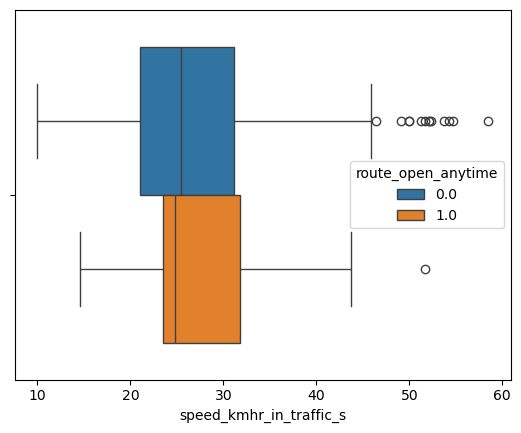

In [27]:
sns.boxplot(data=route_mean_df, x="speed_kmhr_in_traffic_s", hue="route_open_anytime")

### Exercise: Compare distribution of *95th percentile* speeds along BRT and non-BRT routes. Make a figure showing the difference.
1. Compute the 95th percentile speed along each route (__hint__ use `quantile(0.95)` instead of `mean()`
2. Make a boxplot

### Exercise: Take average speed for each route within each hour of day. Plot distriubtion of average speeds across routes for each hour.

In [30]:
route_hour_df = google_tt_df.\
    groupby(['lat_o', 'lon_o', 'lat_d', 'lon_d' , 'hour'])['speed_kmhr_in_traffic_s'].\
    mean().\
    compute().\
    reset_index()

<Axes: xlabel='hour', ylabel='speed_kmhr_in_traffic_s'>

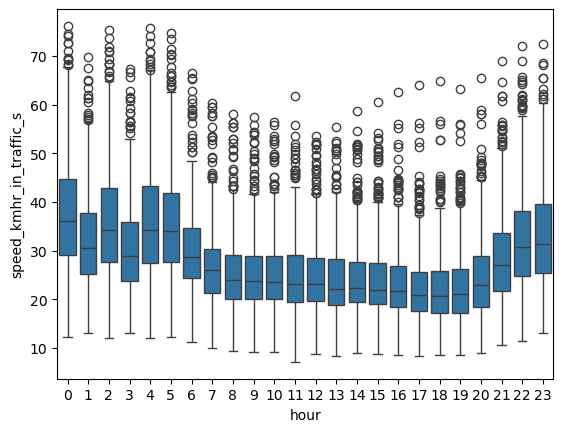

In [31]:
sns.boxplot(data=route_hour_df, x="hour", y = "speed_kmhr_in_traffic_s")

### Exercise: Take average speed for each route within each hour of day, by BRT and non-BRT routes. Plot distriubtion of average speeds across routes for each hour.

In [39]:
route_hour_df = google_tt_df.\
    groupby(['lat_o', 'lon_o', 'lat_d', 'lon_d' , 'hour', 'route_open_anytime'])['speed_kmhr_in_traffic_s'].\
    mean().\
    compute().\
    reset_index()

<Axes: xlabel='hour', ylabel='speed_kmhr_in_traffic_s'>

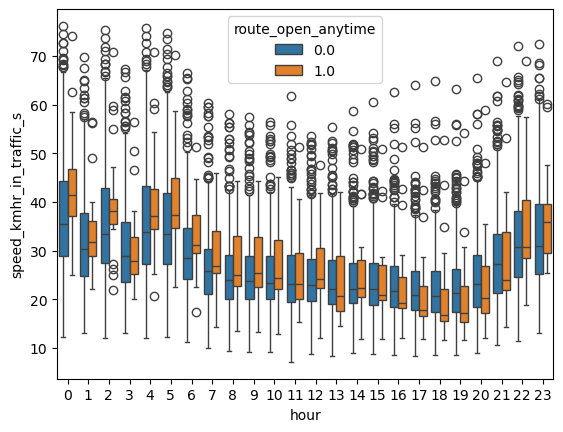

In [40]:
#route_hour_df['route_open_anytime'] = route_hour_df['route_open_anytime'].apply(str)

sns.boxplot(data=route_hour_df, x="hour", y = "speed_kmhr_in_traffic_s",
           hue = 'route_open_anytime')

### Exercise: Determine the distance from each route to Ikeja BRT terminal. Compare average speed between routes within 5 kilometers of Ikeja BRT terminal and other routes.

In [44]:
# Make GeoDataFrame of Ikeja Bus Terminal

# Make pandas dataframe
ikeja_df = pd.DataFrame(
    {
        "Name": ["Ikeja"],
        "Latitude": [6.5919],
        "Longitude": [3.3392],
    }
)

# Convert to geopandas dataframe
ikeja_gdf = gpd.GeoDataFrame(
    ikeja_df, geometry=gpd.points_from_xy(ikeja_df.Longitude, ikeja_df.Latitude), crs="EPSG:4326"
)

In [45]:
# Project to UTM; units are now in meters
utm_epsg_code = "32631"
ikeja_gdf_utm = ikeja_gdf.to_crs(epsg=utm_epsg_code)
route_gpd_utm = route_gpd.to_crs(epsg=utm_epsg_code)

In [46]:
# Determine which routes are within 5km of Ikeja

## Grab shapely geometry
ikeja_point = ikeja_gdf_utm.geometry.iloc[0]

## Calculate the distance
route_gpd['distance_to_ikeja'] = route_gpd_utm.geometry.distance(ikeja_gdf_utm)
route_gpd['5km_to_ikeja'] = route_gpd['distance_to_ikeja'] <= 5000

/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/ipykernel_27114/322931937.py:7: UserWarning: The indices of the two GeoSeries are different.
  route_gpd['distance_to_ikeja'] = route_gpd_utm.geometry.distance(ikeja_gdf_utm)


In [47]:
# Define a function to add hour and day of week variable
def merge_route(df):
    df = df.merge(route_gpd, on = ["lat_o", "lon_o", "lat_d", "lon_d"], how = "left")
    return df

# Apply the function to each partition of the Dask DataFrame
google_tt_route_df = google_tt_df.map_partitions(merge_route)

In [48]:
google_tt_route_df['speed_kmhr_in_traffic_s'][google_tt_route_df['5km_to_ikeja'] == True].\
    describe().\
    compute()

count    60476.000000
mean        23.744511
std          8.706372
min          7.103670
25%         19.180544
50%         24.329927
75%         34.993511
max         56.605198
Name: speed_kmhr_in_traffic_s, dtype: float64

In [49]:
google_tt_route_df['speed_kmhr_in_traffic_s'][google_tt_route_df['5km_to_ikeja'] == False].\
    describe().\
    compute()

count    8.576418e+07
mean     2.627019e+01
std      1.135724e+01
min      1.915756e+00
25%      2.123642e+01
50%      2.689839e+01
75%      3.439071e+01
max      9.286829e+01
Name: speed_kmhr_in_traffic_s, dtype: float64

# Part 3: Speed by location

### Exercise: Take average speed by route and plot histogram of speeds

__Hint:__ 
1. Group by coordinates, `['lat_o', 'lon_o', 'lat_d', 'lon_d']`
2. Take average speed across coordinates
3. Use `sns.histplot` to show distribution of speeds

### Exercise: Take average speed by route, merge speeds with route, and make a map of speeds

__Hint__
1. Merge `route_gpd` with the dataset created above on the coordinates, `['lat_o', 'lon_o', 'lat_d', 'lon_d']`
2. Make the map